## Data preprocessing

code in this section written by Beiming Cao

In [ ]:
import os
import glob
import csv
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy.io import wavfile
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
data_path = ''
EMA_path_list = glob.glob(data_path + '/*.csv')
WAV_path_list = glob.glob(data_path + '/*.wav')
EMA_path_list.sort()
WAV_path_list.sort()

In [ ]:
# index D1T1 0 is bad data

# THIS Is what you change to get a different "recording" which has the 8 spoken vowels you need to parse
index = 19
sample_wav_path = WAV_path_list[index]
sample_ema_path = EMA_path_list[index]
data = np.loadtxt(sample_ema_path, delimiter=',', skiprows=1)
fs, I = wavfile.read(sample_wav_path)

pos = data[:,0:3]
raw = data[:,3:6]
ori = data[:,6:8]

ema_dur = data.shape[0]
wav_dur = I.shape[0]
ratio = wav_dur/ema_dur

In [ ]:
# displays the graphs

fig, [axes1, axes2, axes3, axes4] = plt.subplots(4,1, figsize=(15,6))

offset = 80

starts = np.array([70, 450, 850, 1260, 1680, 2030, 2460, 2830])+offset
ends = np.array([370, 730, 1150, 1550, 1940, 2350, 2765, 3100])+offset

wav_starts = starts * ratio
wav_ends = ends * ratio
axes1.plot(pos[:,0])
# axes1.set_xticks(np.arange(start=0, stop=2500, step=100))
axes1.set_ylabel("Tx")
axes2.plot(pos[:,1])
# axes2.set_xticks(np.arange(start=0, stop=2500, step=100))
axes2.set_ylabel("Ty")
axes3.plot(pos[:,2])
# axes3.set_xticks(np.arange(start=0, stop=2500, step=100))
axes3.set_ylabel("Tz")
axes4.plot(I)
# x axis of the plots is index position
for xc in starts:
    axes1.axvline(x=xc, color='r')    
for xc in ends:
    axes1.axvline(x=xc, color='k')
for xc in starts:
    axes2.axvline(x=xc, color='r')    
for xc in ends:
    axes2.axvline(x=xc, color='k')   
for xc in starts:
    axes3.axvline(x=xc, color='r')
for xc in ends:
    axes3.axvline(x=xc, color='k')    
for xc in wav_starts:
    axes4.axvline(x=xc, color='r')     
for xc in wav_ends:
    axes4.axvline(x=xc, color='k')

In [ ]:
# uses the tags you made to divide into specific vowels files

# starts/ ends contains the time positions of the starting and ending tags

out_dir = ''

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

phrase_ID = 'D2T2_' + format(index, '03d') 

tag_file_name = phrase_ID + '.tag'
tag_out_path = os.path.join(out_dir, tag_file_name)
tag = np.concatenate([starts, ends], axis = 0)

np.savetxt(tag_out_path, tag, delimiter=",", fmt='%1.4f')
# .tag file has positions of all start/end tags
# day# trial# recording#
# each trial has 20 recordings with 8 vowels in each one


for i in range(starts.shape[0]):
    
    phrase_name = phrase_ID + '_' + format(i, '03d') + '.pma'
    output_path = os.path.join(out_dir, phrase_name)
    
    data_output = data[starts[i]:ends[i], :]
    
    np.savetxt(output_path, data_output, delimiter=",", fmt='%1.4f')
  
# .pma file is split data by vowel
# day# trial# recording# vowel#
# each recording has the same vowels in the same order
# 0 = bob
# 1 = beeb
# 2 = babe
# 3 = bab
# 4 = bub
# 5 = bawb
# 6 = bohb
# 7 = boob

#Data analysis

code in this section written by Sidh Pandit

In [ ]:
!pip install tslearn
!pip install qc-procrustes
!pip install pacmap

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import scipy
import seaborn as sns
import matplotlib.ticker as ticker
from random import randint

key = {0:'/bɑb/', 1:'/bib/', 2:'/beb/', 3:'/bæb/', 4:'/bʌb/', 5:'/bɔb/', 6:'/bob/', 7:'/bub/'}
non_bilab_key = {0:'/ɑ/', 1:'/i/', 2:'/e/', 3:'/æ/', 4:'/ʌ/', 5:'/ɔ/', 6:'/o/', 7:'/u/'}
features_key = {0:'x', 1:'y', 2:'z', 3:'Mx', 4:'My', 5:'Mz', 6:'roll', 7:'pitch', 8:'yaw', 9:'qs', 10:'qx', 11:'qy', 12:'qz', 13:'dt'}

#Load data

## from pickle

In [ ]:
import pickle
with open('vowel_dataset.pkl', 'rb') as file:
    vowel_dataset = np.array(pickle.load(file))

with open('s1_vowels.pkl', 'rb') as file:
    s1_vowels = np.array(pickle.load(file))

with open('s1_labels.pkl', 'rb') as file:
    s1_labels = np.array(pickle.load(file))

with open('s2_vowels.pkl', 'rb') as file:
    s2_vowels = np.array(pickle.load(file))

with open('s2_labels.pkl', 'rb') as file:
    s2_labels = np.array(pickle.load(file))

label_dataset = np.loadtxt(fname='label_dataset')

#Data Transforms

### normalize all vowels individually

In [ ]:
def normalize_dataset(vowels):
  scaler = sklearn.preprocessing.StandardScaler()
  normalized_vowels = [scaler.fit_transform(vowel) for vowel in vowels]
  normalized_vowels = np.array(normalized_vowels)
  
  return normalized_vowels

vowel_dataset = normalize_dataset(vowel_dataset)

s1_vowels = normalize_dataset(s1_vowels)

s2_vowels = normalize_dataset(s2_vowels)

### equalize sequence lengths

In [ ]:
#METHODS FOR TRANSFORMING DATA TO BE EQUAL LENGTH
def zoomed(vowels, n):
  zoomed_dataset = np.array([scipy.ndimage.zoom(input=frame, zoom=[n/len(frame),1]) for frame in vowels])
  return zoomed_dataset

### convert to sktime format

In [ ]:
def skt_format(vowel_dataset):
  n_features = vowel_dataset.shape[2]

  vds_skt = pd.DataFrame()
  for i in range(n_features):
    vds_skt[str(i)] = [pd.Series(vowel[ :,i]) for vowel in vowel_dataset]
    # vds_skt[str(i)] = [pd.DataFrame(vowel[ :,i]) for vowel in vowel_dataset]

  return vds_skt

## low pass filtering

In [ ]:
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


In [ ]:
# Filter requirements.
T = 5.0         # Sample Period
fs = 250       # sample rate, Hz
cutoff = 15      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic

def lp(vowels, cutoff=20):
  return np.array([np.apply_along_axis(butter_lowpass_filter, axis=0, arr=vowel, cutoff=cutoff, fs=fs, order=order) for vowel in vowels])

## select features 

In [ ]:
def feature_selection(selected, vowels):
  return np.array([pd.DataFrame(vowel)[selected] for vowel in vowels])

##endpoing fixing for DTW

In [ ]:
def fix_vowel_endpoints(vowel, n_endpoints=10, scaling_factor=0.01):
  vowel[0:n_endpoints] = vowel[0:n_endpoints] * scaling_factor
  vowel[-n_endpoints:] = vowel[-n_endpoints:] * scaling_factor

  return vowel


def fix_endpoints(vowels, n_endpoints=10, scaling_factor=0.01):
  return np.array([fix_vowel_endpoints(vowel) for vowel in vowels])

#Classification (SVM/KNN)

In [ ]:
n_frames = 50
features = [1,2,7]
lp_cutoff = 20

speaker = s1_vowels
speaker = lp(speaker, cutoff=lp_cutoff)
speaker128 = zoomed(speaker, n_frames)
speaker128_features = feature_selection(vowels=speaker128, selected=features)

speaker128_features = fix_endpoints(speaker128_features, n_endpoints=10, scaling_factor=0.01)

data = speaker128_features

labels = s1_labels

X_tr, X_te, y_tr, y_te = train_test_split(data, labels, test_size=0.2, random_state=60, shuffle=True)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.svm import TimeSeriesSVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# clf = KNeighborsTimeSeriesClassifier(n_neighbors=5, weights='distance',
#                                          metric='dtw', metric_params={'global_constraint': 'sakoe_chiba',
#                                                                   'sakoe_chiba_radius': 20})
clf = TimeSeriesSVC(kernel='gak')


cms=[]
accs=[]
for i, (train_indices, test_indices) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=111).split(data, labels)):
  
  X_tr = data[train_indices]
  y_tr = labels[train_indices]

  X_te = data[test_indices]
  y_te = labels[test_indices]

  clf.fit(X_tr, y_tr)

  preds = clf.predict(X_te)

  accs.append(accuracy_score(y_te, preds))
  cms.append(confusion_matrix(y_te, preds,normalize='true'))

In [ ]:
SVMs1_cm = np.mean(np.array(cms), axis=0)
np.savetxt('s1_cm_svm',SVMs1_cm)
SVMs1_cm

array([[0.65  , 0.    , 0.    , 0.175 , 0.05  , 0.075 , 0.05  , 0.    ],
       [0.    , 0.9125, 0.0375, 0.    , 0.    , 0.    , 0.    , 0.05  ],
       [0.    , 0.025 , 0.9375, 0.0125, 0.    , 0.    , 0.0125, 0.0125],
       [0.0875, 0.    , 0.    , 0.8875, 0.0125, 0.0125, 0.    , 0.    ],
       [0.075 , 0.    , 0.    , 0.025 , 0.6125, 0.1625, 0.1125, 0.0125],
       [0.0875, 0.    , 0.    , 0.0875, 0.1   , 0.675 , 0.05  , 0.    ],
       [0.075 , 0.    , 0.025 , 0.025 , 0.2625, 0.0375, 0.5375, 0.0375],
       [0.    , 0.025 , 0.0125, 0.0125, 0.0375, 0.    , 0.0125, 0.9   ]])

In [ ]:
SVMs2_cm = np.mean(np.array(cms), axis=0)
np.savetxt('s2_cm_svm',SVMs2_cm)
SVMs2_cm

array([[0.39684211, 0.        , 0.        , 0.18473684, 0.03157895,
        0.07105263, 0.29578947, 0.02      ],
       [0.        , 0.91842105, 0.03      , 0.        , 0.02105263,
        0.01      , 0.        , 0.02052632],
       [0.        , 0.        , 0.96894737, 0.        , 0.01      ,
        0.        , 0.        , 0.02105263],
       [0.13210526, 0.        , 0.        , 0.58210526, 0.        ,
        0.07157895, 0.20421053, 0.01      ],
       [0.03052632, 0.15315789, 0.02      , 0.01052632, 0.67526316,
        0.01      , 0.05      , 0.05052632],
       [0.03105263, 0.        , 0.        , 0.08052632, 0.01      ,
        0.84736842, 0.03105263, 0.        ],
       [0.13368421, 0.        , 0.        , 0.12210526, 0.02      ,
        0.02      , 0.68421053, 0.02      ],
       [0.        , 0.        , 0.01052632, 0.        , 0.02105263,
        0.        , 0.        , 0.96842105]])

Text(50.722222222222214, 0.5, 'Preds')

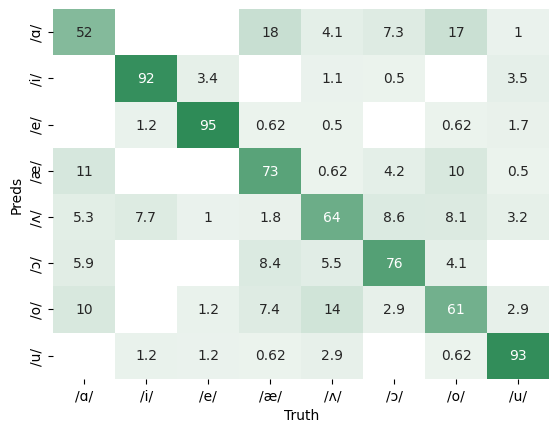

In [ ]:
#FOR SVM
avg_cm = np.mean([SVMs1_cm, SVMs2_cm], axis=0)
avg_cm[np.where(avg_cm==0)]= None

ax = heatmap(avg_cm*100, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True),cbar=False, xticklabels=list(non_bilab_key.values()), yticklabels=list(non_bilab_key.values()))
ax.set_xlabel('Truth')
ax.set_ylabel('Preds')

Text(50.722222222222214, 0.5, 'Preds')

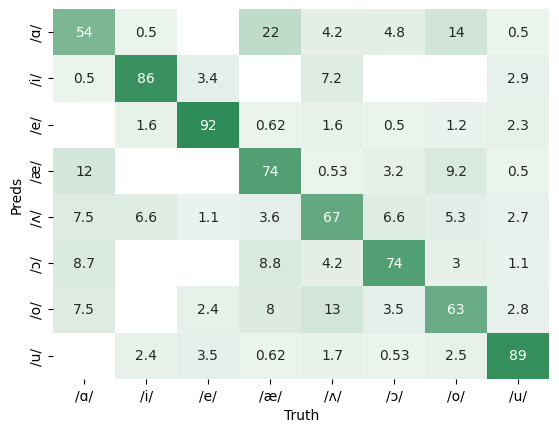

In [ ]:
avg_cm = np.mean((s1_cm_shapelet, s2_cm_shapelet),axis=0)
avg_cm[np.where(avg_cm==0)]= None
ax = heatmap(avg_cm*100, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True),cbar=False, xticklabels=list(non_bilab_key.values()), yticklabels=list(non_bilab_key.values()))
ax.set_xlabel('Truth')
ax.set_ylabel('Preds')

In [ ]:
s2_cm = np.mean(np.array(cms), axis=0)
np.savetxt('s2_cm_knn',s2_cm)
s2_cm

array([[0.54105263, 0.        , 0.01052632, 0.23473684, 0.01052632,
        0.03052632, 0.16263158, 0.01      ],
       [0.        , 0.95947368, 0.01      , 0.        , 0.        ,
        0.01052632, 0.        , 0.02      ],
       [0.        , 0.02      , 0.97      , 0.        , 0.        ,
        0.        , 0.        , 0.01      ],
       [0.17315789, 0.        , 0.        , 0.65210526, 0.01      ,
        0.05105263, 0.11368421, 0.        ],
       [0.05210526, 0.17578947, 0.05052632, 0.04105263, 0.60894737,
        0.01      , 0.03105263, 0.03052632],
       [0.08157895, 0.        , 0.        , 0.15263158, 0.        ,
        0.71368421, 0.05210526, 0.        ],
       [0.23473684, 0.        , 0.        , 0.12052632, 0.        ,
        0.01      , 0.61421053, 0.02052632],
       [0.        , 0.01052632, 0.01      , 0.        , 0.01052632,
        0.        , 0.        , 0.96894737]])

In [ ]:
s1_cm = np.mean(np.array(cms), axis=0)
np.savetxt('s1_cm_knnHIGHER',s1_cm)
s1_cm

array([[0.75  , 0.    , 0.    , 0.1875, 0.0375, 0.    , 0.025 , 0.    ],
       [0.    , 0.975 , 0.0125, 0.    , 0.    , 0.    , 0.    , 0.0125],
       [0.    , 0.    , 0.9875, 0.0125, 0.    , 0.    , 0.    , 0.    ],
       [0.05  , 0.    , 0.    , 0.95  , 0.    , 0.    , 0.    , 0.    ],
       [0.075 , 0.    , 0.    , 0.025 , 0.5875, 0.1375, 0.175 , 0.    ],
       [0.0625, 0.    , 0.    , 0.0375, 0.05  , 0.85  , 0.    , 0.    ],
       [0.0625, 0.    , 0.0125, 0.0125, 0.175 , 0.1375, 0.5875, 0.0125],
       [0.    , 0.0125, 0.    , 0.0125, 0.025 , 0.    , 0.025 , 0.925 ]])

Text(50.722222222222214, 0.5, 'Preds')

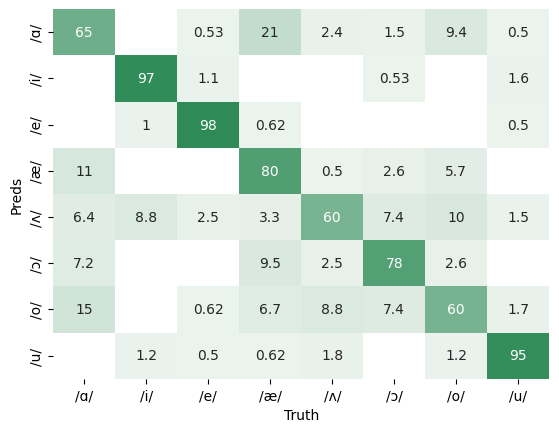

In [ ]:
#FOR KNN
avg_cm = np.mean([s1_cm, s2_cm], axis=0)
avg_cm[np.where(avg_cm==0)]= None

ax = heatmap(avg_cm*100, annot=True, cmap=sns.light_palette("seagreen", as_cmap=True),cbar=False, xticklabels=list(non_bilab_key.values()), yticklabels=list(non_bilab_key.values()))
ax.set_xlabel('Truth')
ax.set_ylabel('Preds')

#Visualizations

## multiple time series

In [ ]:
def multi_ts(data, labels, labels_viz=[0,1,2,3,4,5,6,7], features_viz=[1,2], n_samples=10):
  
  fig, axs = plt.subplots(nrows=len(labels_viz), ncols=len(features_viz),figsize=(27, 15), sharex=True)
  
  for current_label, row in zip(labels_viz, axs):
    
    row[0].set_title(key[current_label], fontdict = {'fontsize':40}, loc='left')

    current_data = data[np.where(labels==current_label)]
    samples = [randint(1, len(current_data)-1) for i in range(n_samples)]

    for current_feature, col in zip(features_viz, row):

      current_data_feature = np.array([vowel[:,current_feature] for vowel in current_data])

      col = sns.lineplot(data=list(current_data_feature[samples]), lw=3, legend=False, dashes=False, ax=col)

      col.set_ylabel(features_key[current_feature], fontdict = {'fontsize':20})
    
  fig.tight_layout()


## generalized procrustes matching

<ipython-input-9-591394d0d89e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.apply_along_axis(butter_lowpass_filter, axis=0, arr=vowel, cutoff=cutoff, fs=fs, order=order) for vowel in vowels])


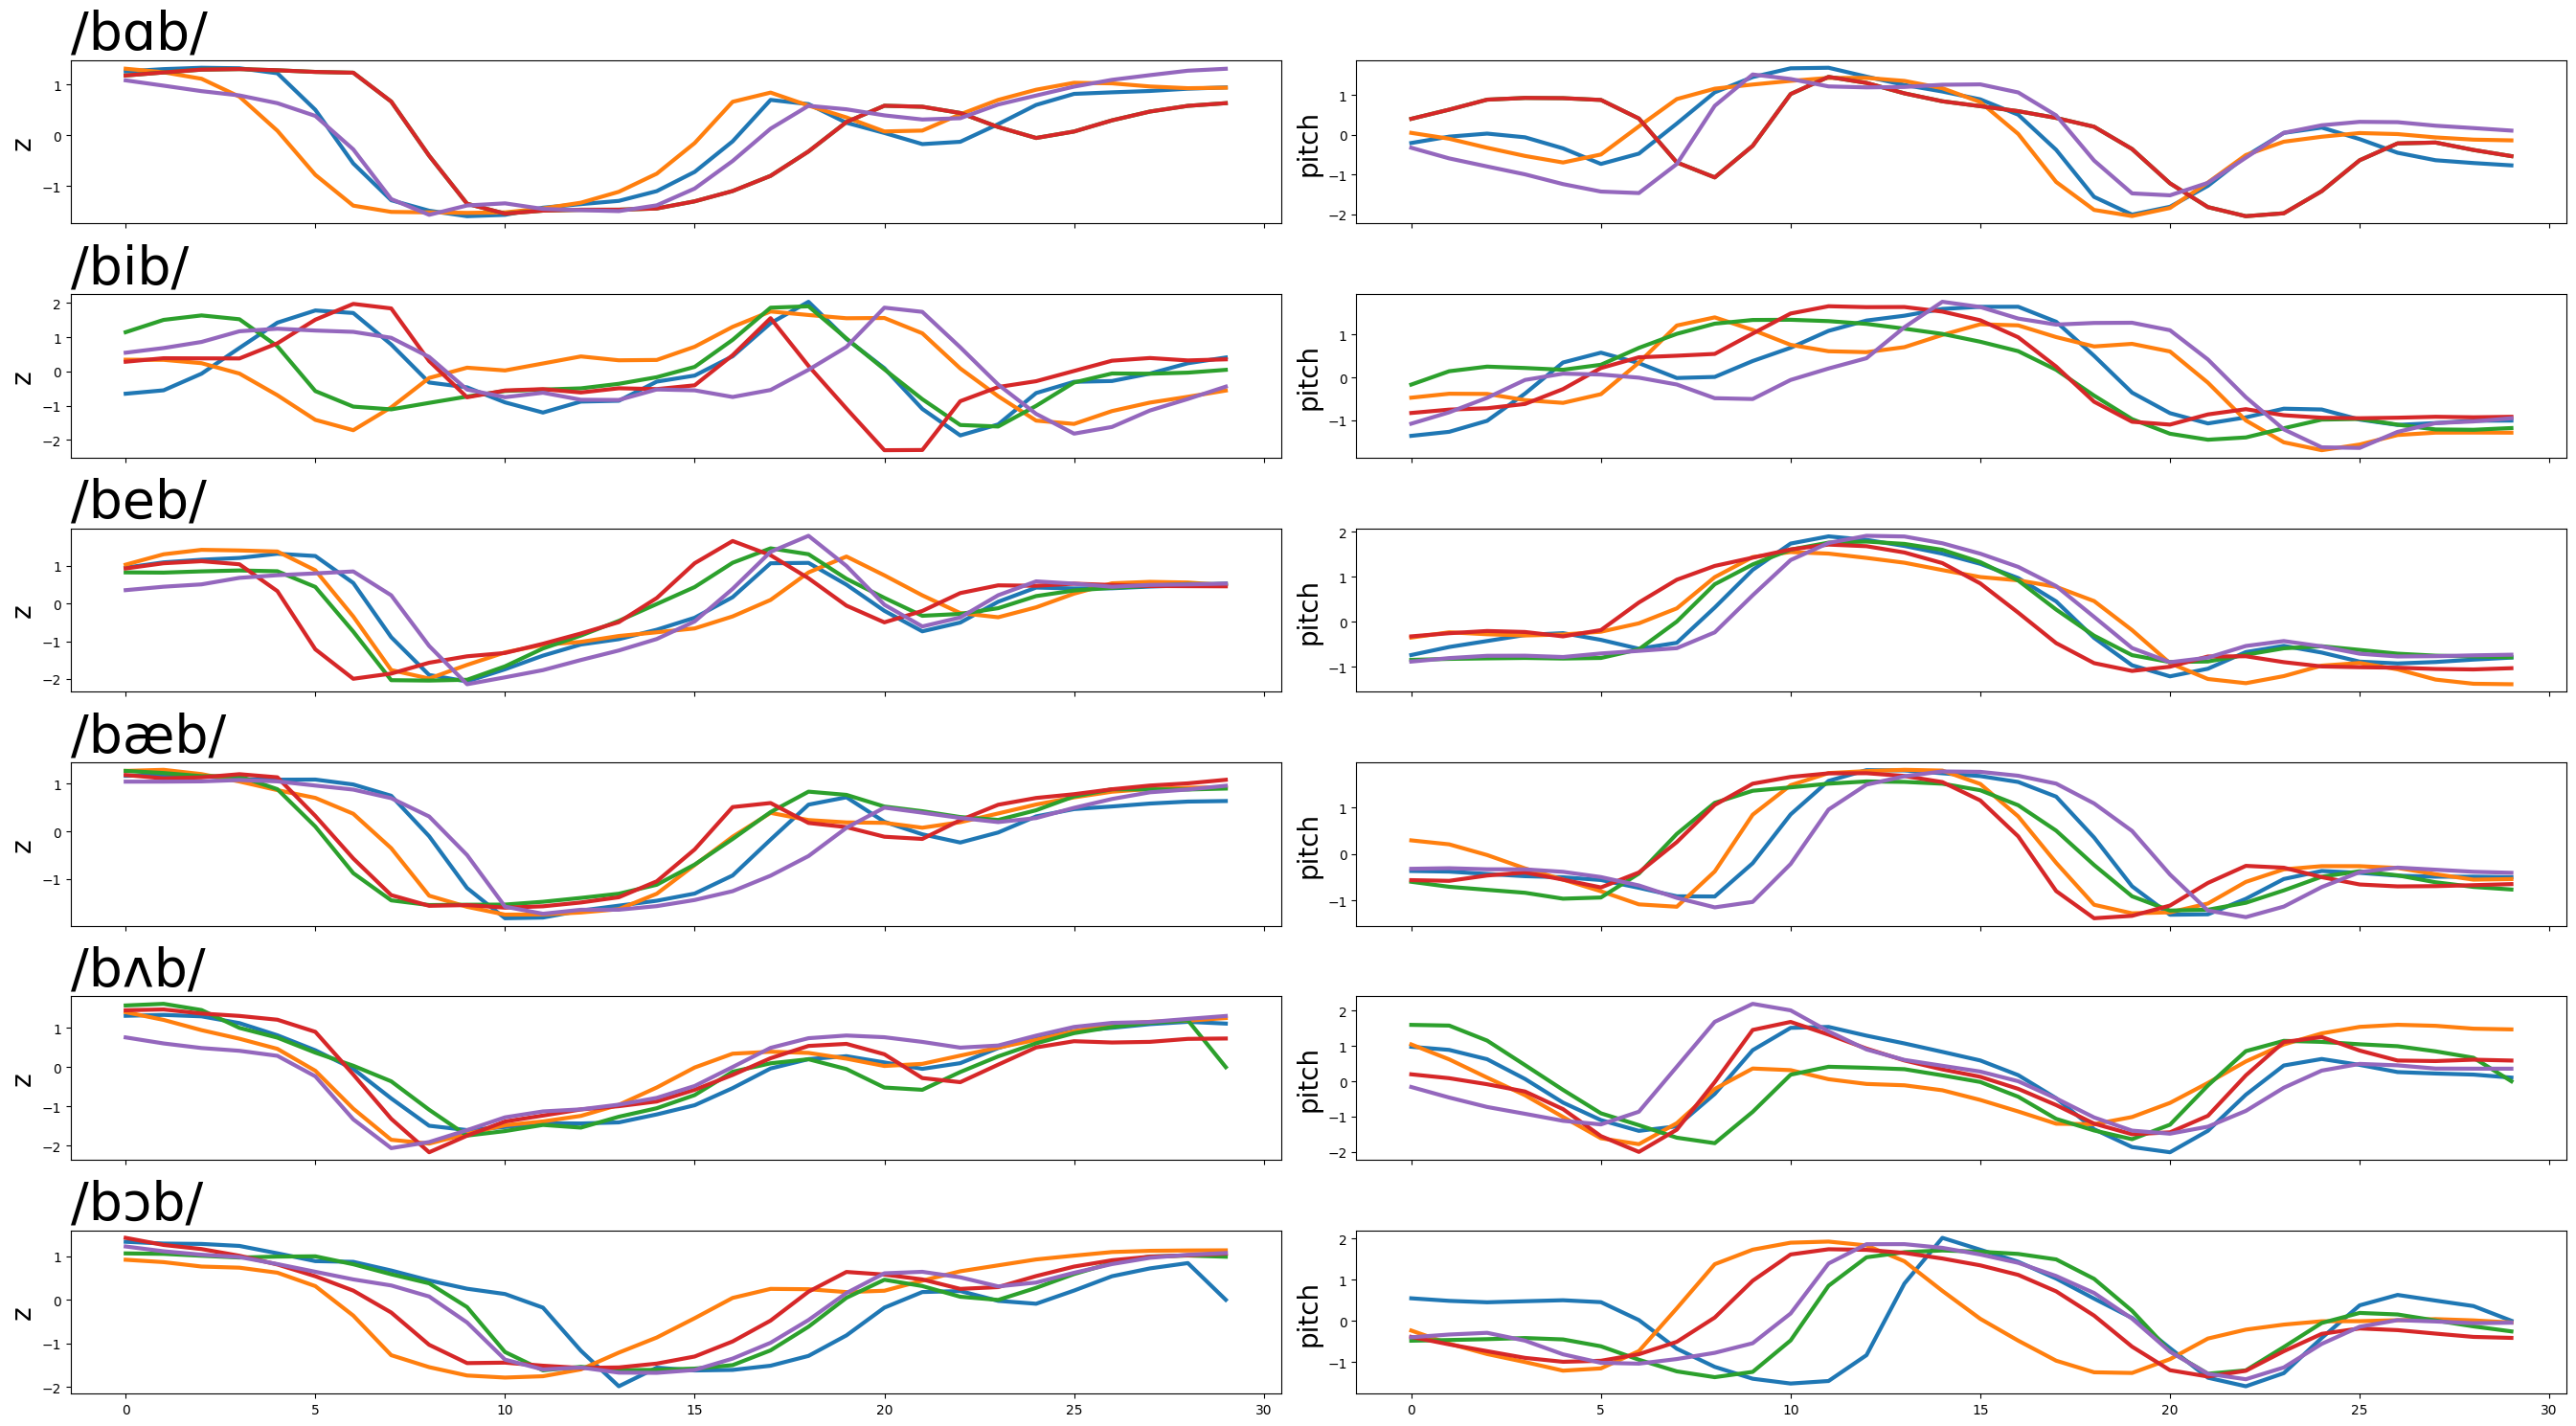

In [ ]:
# BEFORE matching

# data = lp(zoomed(s1_vowels,50),50)

data=lp(s1_vowels,50)
data=zoomed(data, 30)


labels = s1_labels

selected_labels = [0,1,2,3,4,5,6,7]
selected_features = [0]
multi_ts(data=data, labels=labels,
         labels_viz=[0,1,2,3,4,5],
         features_viz=[2,7],
         n_samples=5)

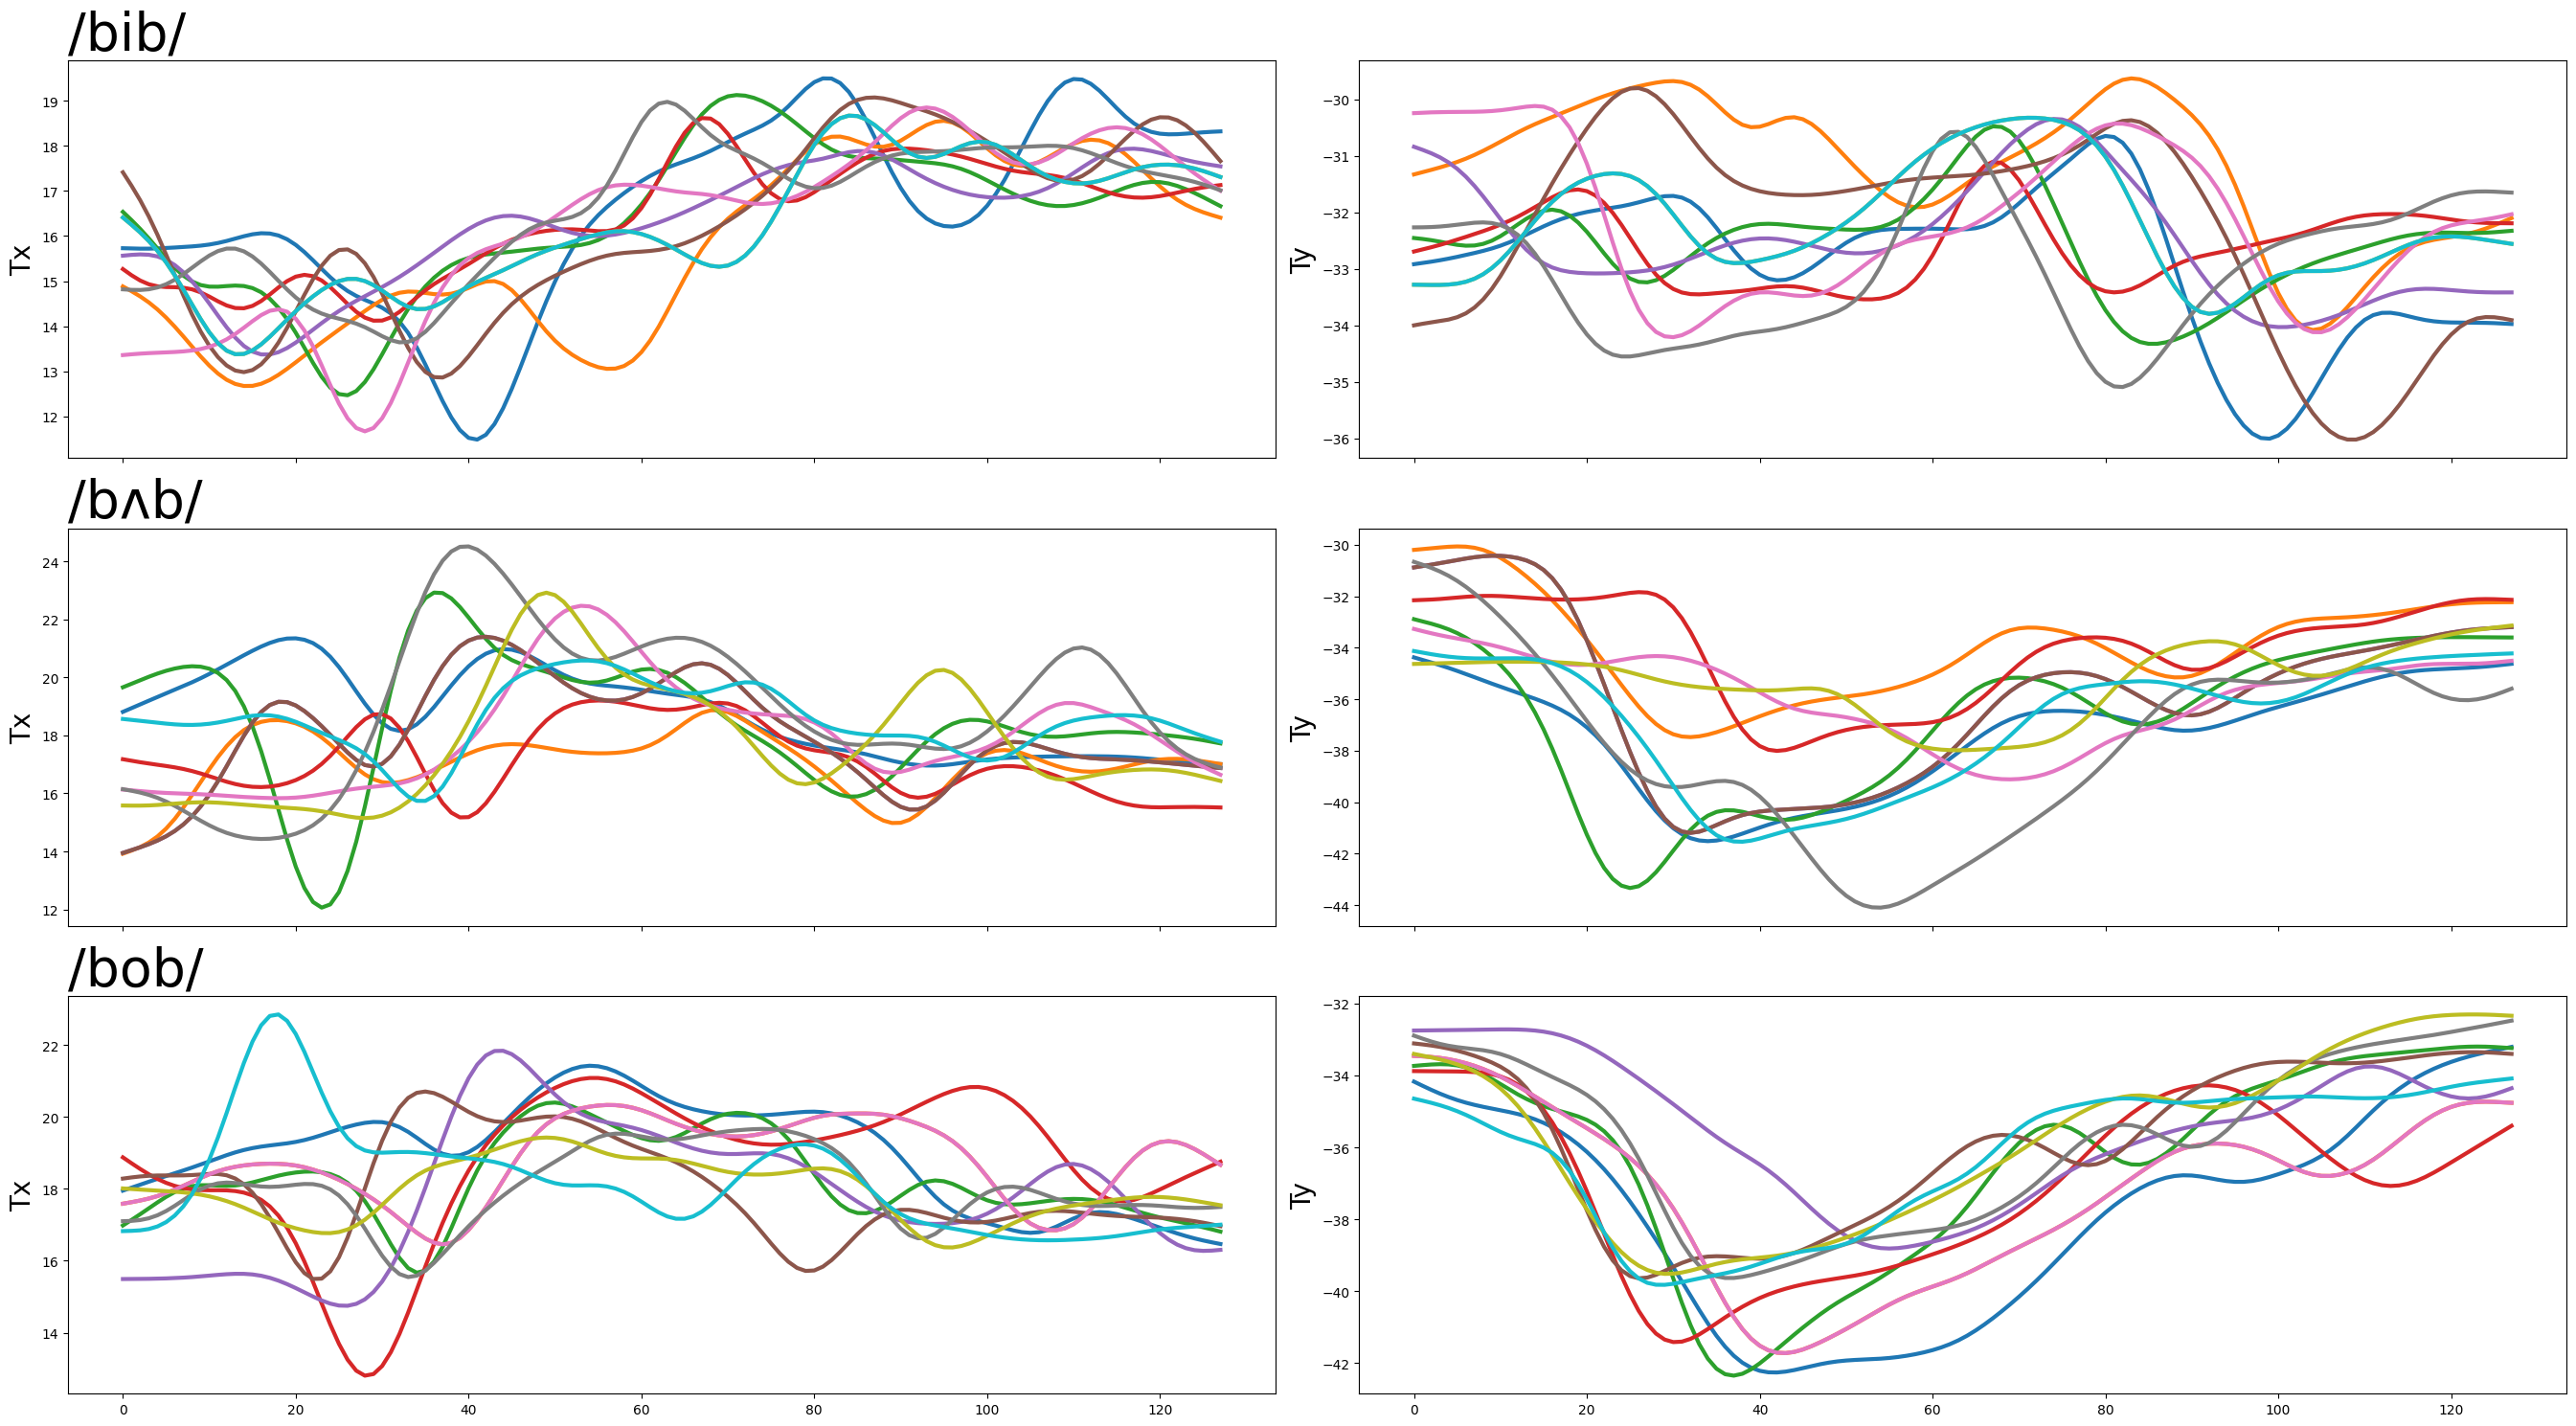

In [ ]:
# AFTER matching (not label specific)

from procrustes import generalized

data = feature_selection(vowels=lp(zoomed(s1_vowels,128)), selected=[1,2])
data = np.array(generalized(data)[0])

labels = s1_labels

selected_labels = [1,4,6]
selected_features = [0,1]
multi_ts(data=data, labels=labels, labels_viz=selected_labels, features_viz=selected_features)

## dtw alignment

In [ ]:
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

vy = [vowel[:,1] for vowel in v128]
vz = [vowel[:,2] for vowel in v128]

key = {0:'/bɑb/', 1:'/bib/', 2:'/beb/', 3:'/bæb/', 4:'/bʌb/', 5:'/bɔb/', 6:'/bob/', 7:'/bub/'}

a=0
b=100


plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

print(key[label_dataset[a]], key[label_dataset[b]])
print(dtw.distance(vz[a], vz[b]))

path = dtw.warping_path(vz[a], vz[b])

fig, axs = plt.subplots(2,1, figsize=(20, 10), sharex=True)
axs[0].set_yticks(ticks=[0,-1,1])
axs[0].set_title(key[label_dataset[a]], loc='left', fontdict = {'fontsize':40})
axs[1].set_xlabel('Frames', fontdict = {'fontsize':20})

axs[0].set_ylabel('Z Amplitude', fontdict = {'fontsize':20})
axs[1].set_ylabel('Z Amplitude', fontdict = {'fontsize':20})

axs[1].set_yticks(ticks=[0,-1,1])
axs[1].set_title(key[label_dataset[b]], loc='left', fontdict = {'fontsize':40})
dtwvis.plot_warping(vz[a], vz[b], path, fig=fig, axs=axs)


plt.show()

#Shapelets

###random shapelet transform + classifier

In [ ]:
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict
grabocka_params_to_shapelet_size_dict(n_ts=700, ts_sz=50, n_classes=8, l=0.5, r=2)

{25: 5, 50: 3}

In [ ]:
from sktime.transformations.panel.shapelet_transform import (RandomShapeletTransform)

n_frames = 50
features = [1,2,6,7]
lp_cutoff = 20

s128 = lp(zoomed(s1_vowels, n_frames), cutoff=lp_cutoff)
s128_yz = feature_selection(vowels=s128, selected=features)

# data = data[np.logical_or(np.logical_or(labels==4, labels==5), labels==6)]
data = skt_format(s128_yz)

# labels= labels[np.logical_or(np.logical_or(labels==4, labels==5), labels==6)]
labels = s1_labels

X_train, X_te, y_train, y_te = train_test_split(data, labels, test_size=0.2, random_state=123, shuffle=True)

transformer = RandomShapeletTransform(max_shapelets=30,
                                      max_shapelet_length=10)

transformer.fit(X_train, y_train)

Xtr_transformed = transformer.transform(X_train)
Xte_transformed = transformer.transform(X_te)

In [ ]:
shapelet_result_key = ('shapelet information gain',' shapelet length', 'start position the shapelet was extracted from', 'shapelet dimension',' index of the instance the shapelet was extracted from in fit', 'class value of the shapelet', 'The z-normalised shapelet array')

shapelet_result_key

('shapelet information gain',
 ' shapelet length',
 'start position the shapelet was extracted from',
 'shapelet dimension',
 ' index of the instance the shapelet was extracted from in fit',
 'class value of the shapelet',
 'The z-normalised shapelet array')

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(Xtr_transformed, y_train)
results(clf.predict(Xte_transformed),y_te)

overall  0.3203125
/bɑb/ 0.5
/bib/ 1.0
/beb/ 0.0
/bæb/ 0.1111111111111111
/bʌb/ 0.0
/bɔb/ 0.6666666666666666
/bob/ 0.0
/bub/ 0.7333333333333333


###kfold final results

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

n_frames = 50
features = [1,2,7]
lp_cutoff = 20

speaker = s1_vowels
speaker = lp(speaker, cutoff=lp_cutoff)
speaker128 = zoomed(speaker, n_frames)
speaker128_features = feature_selection(vowels=speaker128, selected=features)

# speaker128_features = fix_endpoints(speaker128_features, n_endpoints=10, scaling_factor=0.01)

data = skt_format(speaker128_features)

labels = s1_labels


cms=[]
accs=[]

shapelet_insights = []
for i, (train_indices, test_indices) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=111).split(data, labels)):
  
  X_tr = data.iloc[train_indices]
  y_tr = labels[train_indices]

  X_te = data.iloc[test_indices]
  y_te = labels[test_indices]

  transformer = RandomShapeletTransform(max_shapelets=30)

  transformer.fit(X_tr, y_tr)

  Xtr_transformed = transformer.transform(X_tr)
  Xte_transformed = transformer.transform(X_te)

    
  clf = SVC(kernel='linear')
  clf.fit(Xtr_transformed, y_tr)
  results(clf.predict(Xte_transformed),y_te)

  preds = clf.predict(Xte_transformed)

  shapelet_insights.append(transformer.shapelets)
  accs.append(accuracy_score(y_te, preds))
  cms.append(confusion_matrix(y_te, preds,normalize='true'))

<ipython-input-9-591394d0d89e>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.apply_along_axis(butter_lowpass_filter, axis=0, arr=vowel, cutoff=cutoff, fs=fs, order=order) for vowel in vowels])


overall  0.8515625
/bɑb/ 0.9375
/bib/ 0.8125
/beb/ 0.9375
/bæb/ 0.875
/bʌb/ 0.8125
/bɔb/ 0.875
/bob/ 0.6875
/bub/ 0.875
overall  0.75
/bɑb/ 0.6875
/bib/ 0.875
/beb/ 0.9375
/bæb/ 0.9375
/bʌb/ 0.75
/bɔb/ 0.625
/bob/ 0.4375
/bub/ 0.75
overall  0.765625
/bɑb/ 0.4375
/bib/ 1.0
/beb/ 0.875
/bæb/ 1.0
/bʌb/ 0.6875
/bɔb/ 0.5625
/bob/ 0.75
/bub/ 0.8125
overall  0.7265625
/bɑb/ 0.625
/bib/ 1.0
/beb/ 0.875
/bæb/ 0.9375
/bʌb/ 0.3125
/bɔb/ 0.6875
/bob/ 0.5625
/bub/ 0.8125
overall  0.765625
/bɑb/ 0.6875
/bib/ 0.9375
/beb/ 0.9375
/bæb/ 0.875
/bʌb/ 0.625
/bɔb/ 0.6875
/bob/ 0.4375
/bub/ 0.9375


#### previous results

In [ ]:
#shapelet s1
shapelet_s1_cm = np.mean(np.array(cms), axis=0)
np.savetxt('s1_cm_shapelet',shapelet_s1_cm)
shapelet_s1_cm

array([[0.675 , 0.    , 0.    , 0.2125, 0.0625, 0.025 , 0.025 , 0.    ],
       [0.    , 0.925 , 0.0375, 0.    , 0.    , 0.    , 0.    , 0.0375],
       [0.    , 0.0125, 0.9125, 0.0125, 0.0125, 0.    , 0.025 , 0.025 ],
       [0.0625, 0.    , 0.    , 0.925 , 0.    , 0.0125, 0.    , 0.    ],
       [0.1   , 0.    , 0.    , 0.0625, 0.6375, 0.1125, 0.075 , 0.0125],
       [0.0625, 0.    , 0.    , 0.125 , 0.0625, 0.6875, 0.05  , 0.0125],
       [0.0375, 0.    , 0.0375, 0.0375, 0.2375, 0.05  , 0.575 , 0.025 ],
       [0.    , 0.0375, 0.05  , 0.0125, 0.0125, 0.    , 0.05  , 0.8375]])

In [ ]:
import pickle
with open('s1_shapelets.pkl', 'wb') as f:
  pickle.dump(shapelet_insights, f)

In [ ]:
#shapelet s1
accs

[0.8515625, 0.75, 0.765625, 0.7265625, 0.765625]

In [ ]:
#s2
shapelet_s2_cm = np.mean(np.array(cms), axis=0)
np.savetxt('s2_cm_shapelet',shapelet_s2_cm)
shapelet_s2_cm

array([[0.40842105, 0.01      , 0.        , 0.22315789, 0.02105263,
        0.07105263, 0.25631579, 0.01      ],
       [0.01      , 0.79578947, 0.03052632, 0.        , 0.14315789,
        0.        , 0.        , 0.02052632],
       [0.        , 0.02      , 0.92894737, 0.        , 0.02      ,
        0.01      , 0.        , 0.02105263],
       [0.18315789, 0.        , 0.        , 0.56105263, 0.01052632,
        0.05105263, 0.18421053, 0.01      ],
       [0.05052632, 0.13157895, 0.02105263, 0.01      , 0.69578947,
        0.02      , 0.03052632, 0.04052632],
       [0.11157895, 0.        , 0.        , 0.05105263, 0.02052632,
        0.79631579, 0.01052632, 0.01      ],
       [0.11315789, 0.        , 0.01052632, 0.12263158, 0.02      ,
        0.02052632, 0.68315789, 0.03      ],
       [0.        , 0.01052632, 0.02052632, 0.        , 0.02105263,
        0.01052632, 0.        , 0.93736842]])

In [ ]:
import pickle
with open('s2_shapelets.pkl', 'wb') as f:
  pickle.dump(shapelet_insights, f)

In [ ]:
#shapelet s2
accs

[0.7579617834394905,
 0.7388535031847133,
 0.6923076923076923,
 0.6923076923076923,
 0.7435897435897436]

#### load previous results

In [ ]:
s1_cm_shapelet = np.loadtxt('s1_cm_shapelet')
s2_cm_shapelet = np.loadtxt('s2_cm_shapelet')

with open('s1_shapelets.pkl', 'rb') as f:
  s1_shapelets = pickle.load(f)

with open('s2_shapelets.pkl', 'rb') as f:
  s2_shapelets = pickle.load(f)


In [ ]:
from sklearn.model_selection import StratifiedKFold
train_is = []
test_is = []
for i, (train_indices, test_indices) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=111).split(data, labels)):
  print(type(train_indices))
  train_is.append(train_indices)
  test_is.append(test_indices)

### visualize kfold results

In [ ]:
n_frames = 50
features = [1,2,7]
lp_cutoff = 20

speaker = s1_vowels
speaker = lp(speaker, cutoff=lp_cutoff)
speaker128 = zoomed(speaker, n_frames)
speaker128_features = feature_selection(vowels=speaker128, selected=features)

# speaker128_features = fix_endpoints(speaker128_features, n_endpoints=10, scaling_factor=0.01)

data = skt_format(speaker128_features)

labels = s1_labels

<ipython-input-43-8ce3daca9f72>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


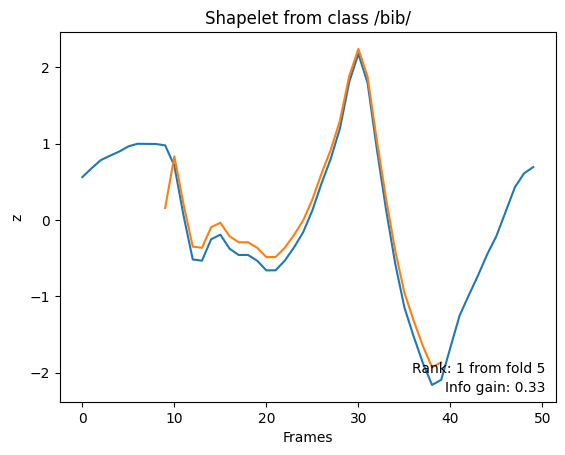

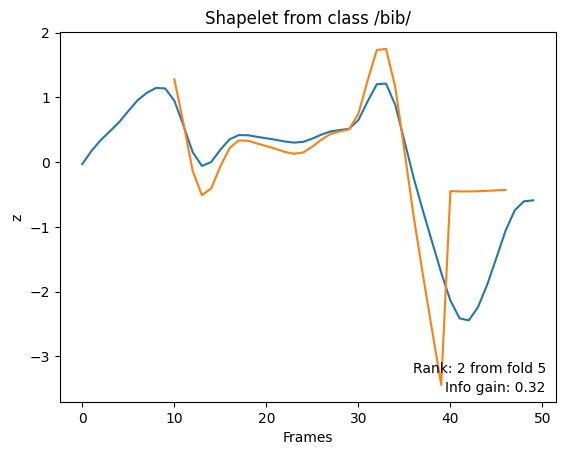

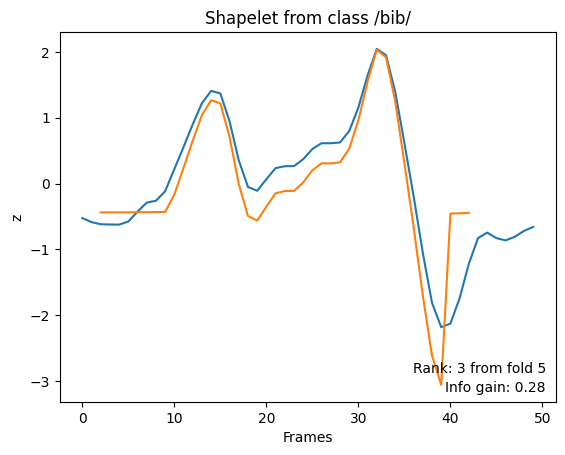

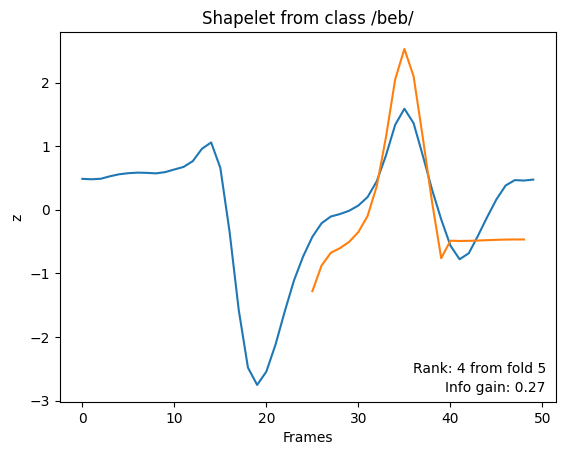

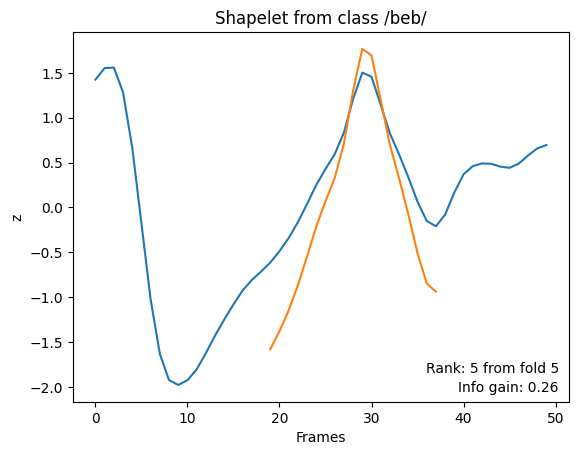

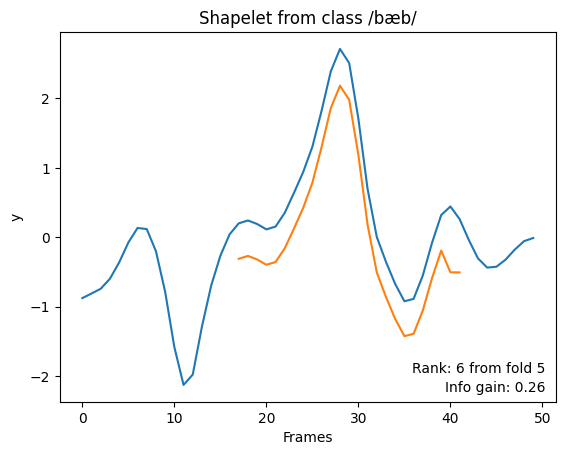

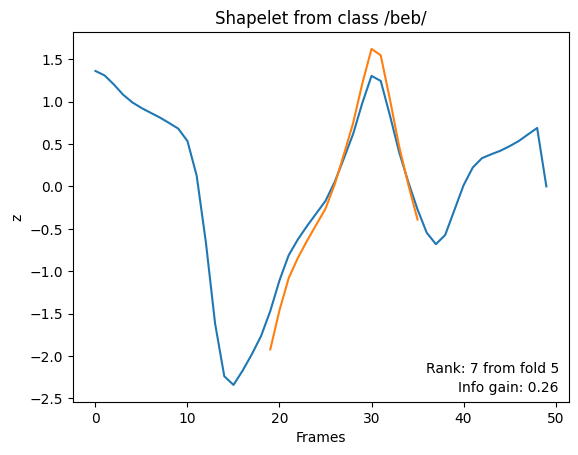

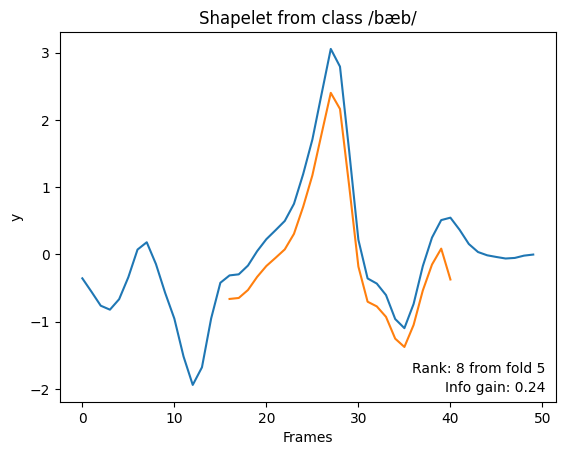

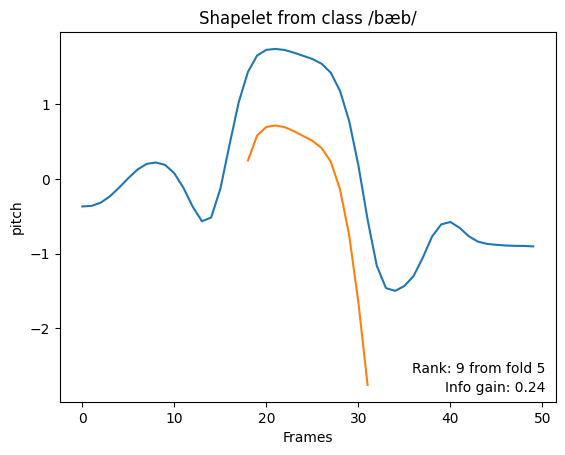

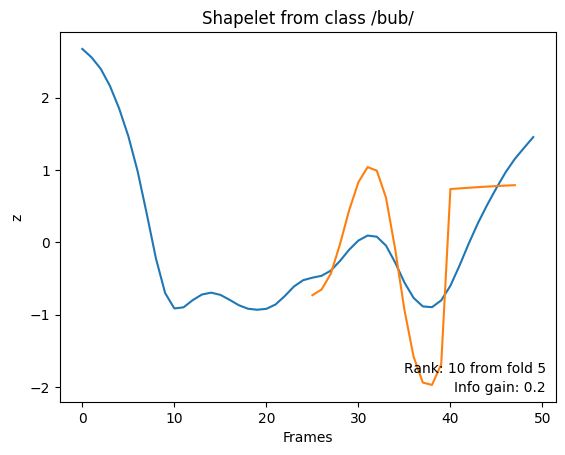

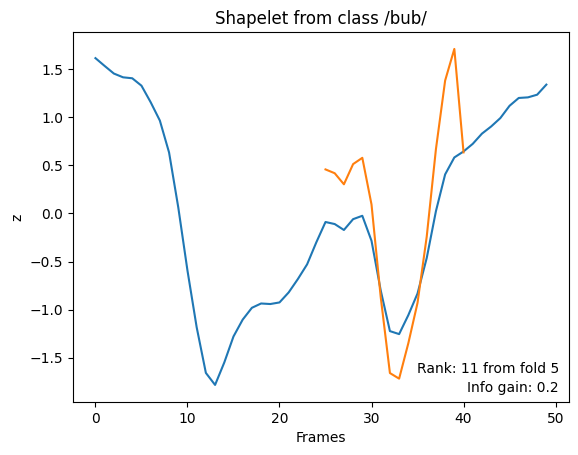

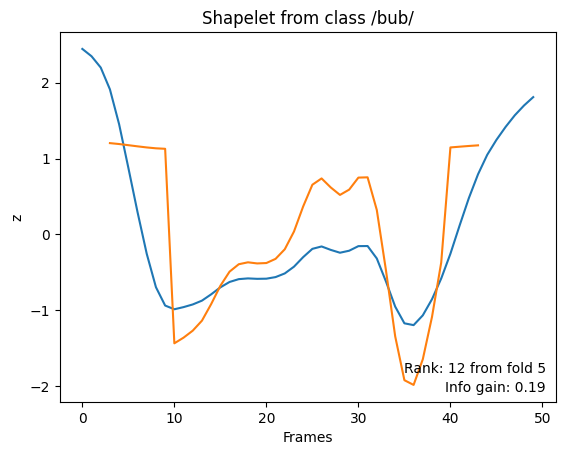

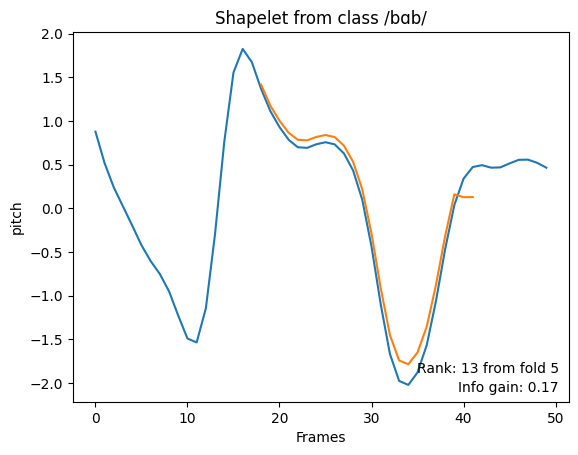

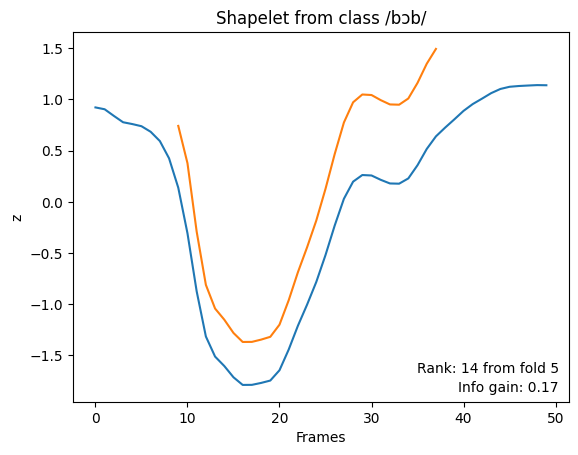

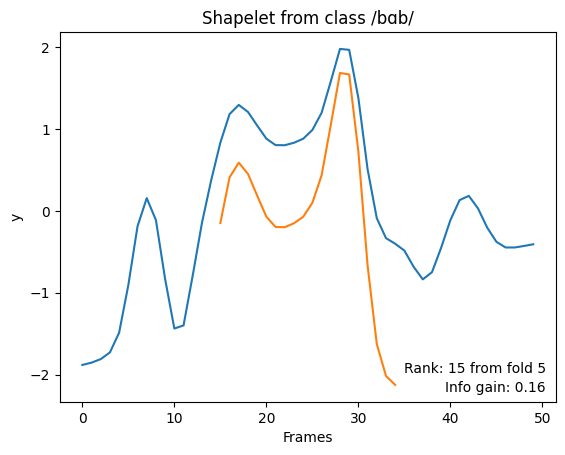

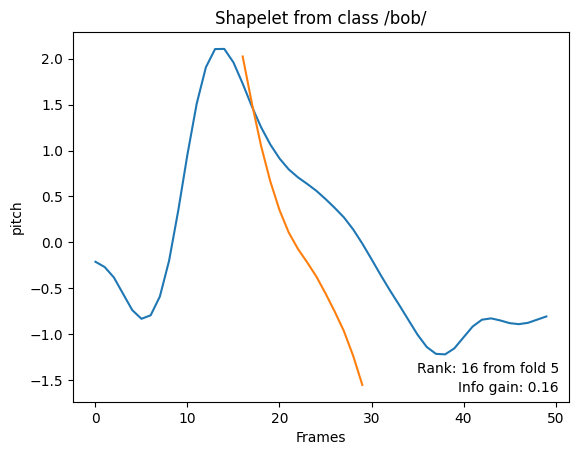

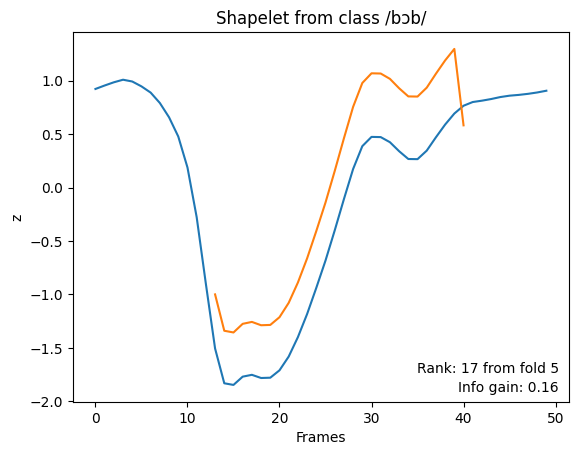

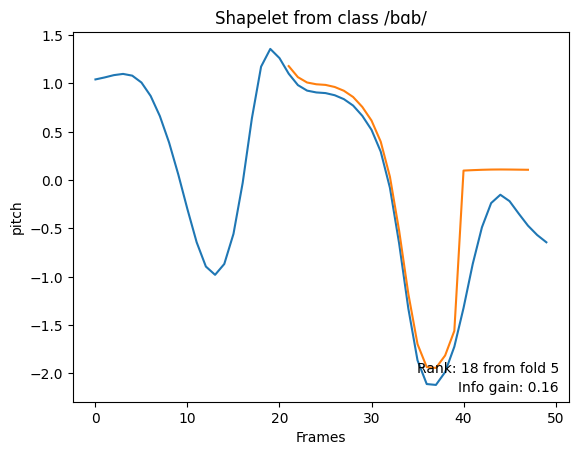

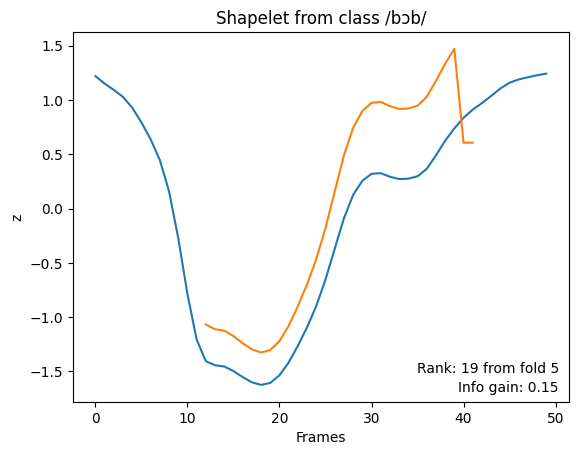

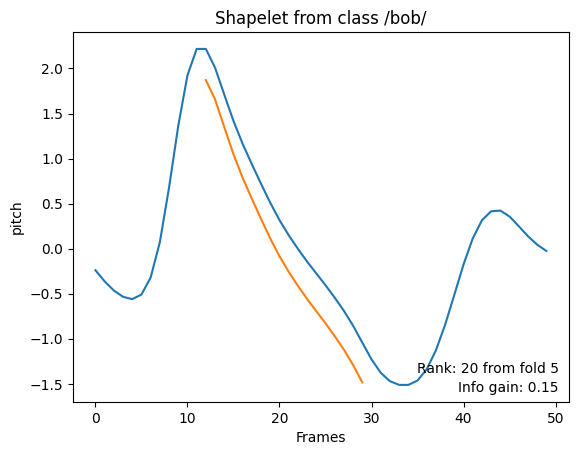

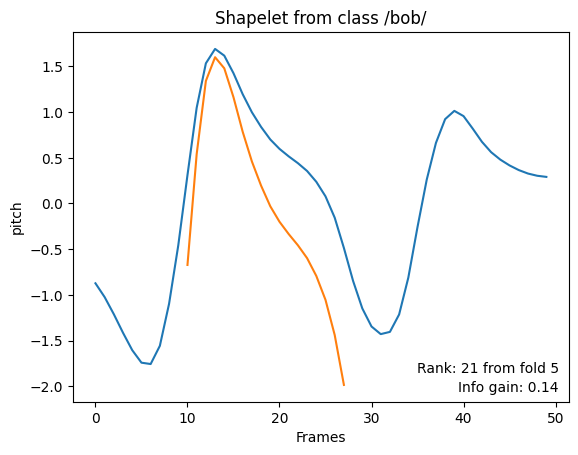

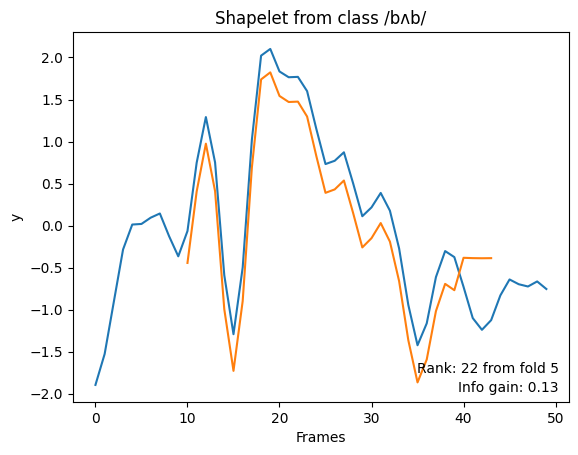

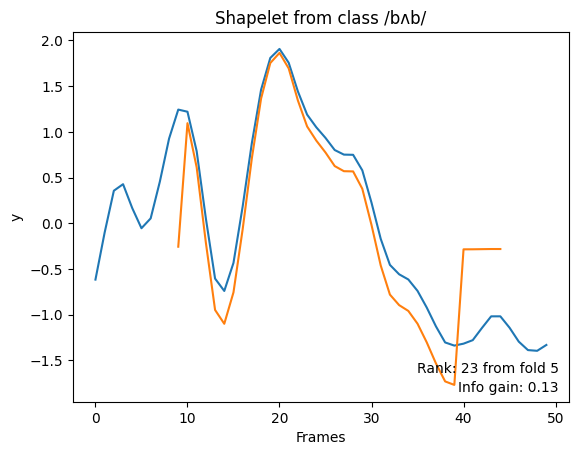

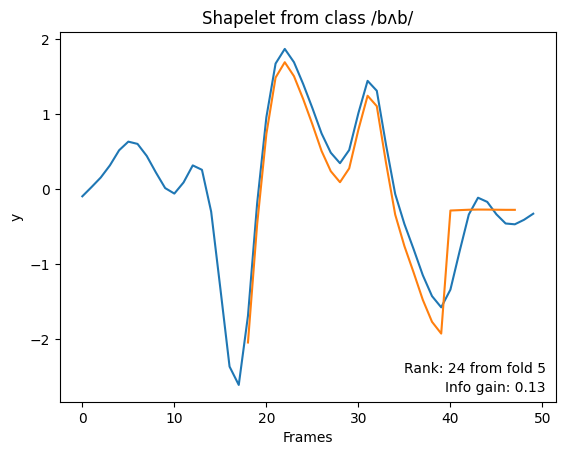

In [ ]:
for i,fold in enumerate(s1_shapelets):
  if(i!=4):
    continue
  for b,shapelet in enumerate(fold):

    info_gain = shapelet[0]
    dim = shapelet[3]
    inst = shapelet[4]
    start = shapelet[2]
    
    lab = shapelet[5]
    subseq = shapelet[6]

    seq = data.iloc[train_is[i]].iloc[inst][dim]


    subseq = pd.DataFrame(subseq)

    subseq['index'] = [start+i for i in range(len(subseq))]

    plt.figure()

    plt.plot(seq)
    plt.plot(subseq['index'], subseq[0])

    plt.title("Shapelet from class "+str(key[lab]))
    plt.xlabel("Frames")
    plt.ylabel(features_key[dim_key[dim]])

    plt.annotate('Info gain: '+str(round(info_gain,2)), xy=(0.98, 0.02),xycoords='axes fraction', fontsize=10, horizontalalignment='right', verticalalignment='bottom')
    plt.annotate('Rank: ' + str(b+1) + ' from fold ' + str(i+1), xy=(0.98, 0.07),xycoords='axes fraction', fontsize=10, horizontalalignment='right', verticalalignment='bottom')


  


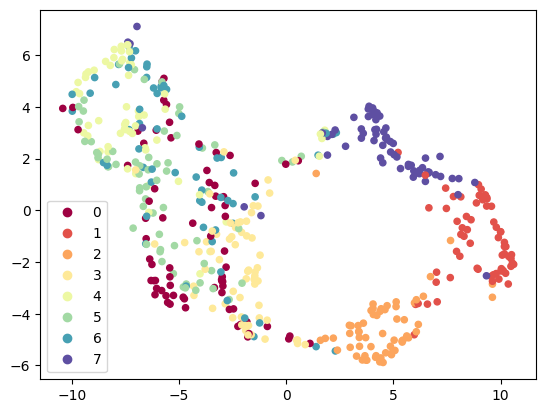

In [ ]:
import pacmap
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(Xtr_transformed, init="pca")

# fig, ax= plt.subplots(1, 1, figsize=(12, 12))
scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap="Spectral", c=y_train, s=20)
plt.legend(*scatter.legend_elements())

#Clustering (K-Means)

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

km_dba = TimeSeriesKMeans(n_clusters=8, metric="dtw",
                          random_state=0).fit(X_tr)

In [ ]:
# these are the clusters that kmeans assigned each training example to 
preds = km_dba.predict(X_tr) 

In [ ]:
for i in range(8):
  lst = list(y_tr[np.where(preds==i)])
  true_label = max(set(lst), key=lst.count)
  print(true_label)

  print('Cluster ', i)
  print('Majority label', true_label)
  print('Entropy score', scipy.stats.entropy(lst))
  print('% majority label, ', lst.count(true_label)/len(lst))
  print()

0.0
Cluster  0
Majority label 0.0
Entropy score 4.6331778357381666
% majority label,  0.29411764705882354

2.0
Cluster  1
Majority label 2.0
Entropy score 4.8723257441969
% majority label,  0.35403726708074534

1.0
Cluster  2
Majority label 1.0
Entropy score 3.9360933016748207
% majority label,  0.7341772151898734

5.0
Cluster  3
Majority label 5.0
Entropy score 5.333137414478633
% majority label,  0.21189591078066913

1.0
Cluster  4
Majority label 1.0
Entropy score 4.250112110628308
% majority label,  0.4935064935064935

4.0
Cluster  5
Majority label 4.0
Entropy score 4.740219805319883
% majority label,  0.4318181818181818

7.0
Cluster  6
Majority label 7.0
Entropy score 4.3755709825751286
% majority label,  0.8902439024390244

6.0
Cluster  7
Majority label 6.0
Entropy score 4.94316279799518
% majority label,  0.29347826086956524

